In [1]:
from Environments.SimpleMarket import SimpleMarket
import numpy as np
import matplotlib.pyplot as plt
import ray
import gym
from ray.tune.registry import register_env
from ray.rllib.agents.a3c.a3c import DEFAULT_CONFIG, A3CTrainer
import os
import gc
gc.collect()

80

In [2]:
ray.shutdown()

In [3]:
ray.init()

2020-10-27 18:59:22,366	INFO resource_spec.py:231 -- Starting Ray with 12.55 GiB memory available for workers and up to 6.29 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-27 18:59:22,913	INFO services.py:1193 -- View the Ray dashboard at localhost:8267


{'node_ip_address': '192.168.1.103',
 'raylet_ip_address': '192.168.1.103',
 'redis_address': '192.168.1.103:62308',
 'object_store_address': '/tmp/ray/session_2020-10-27_18-59-22_365349_10337/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-10-27_18-59-22_365349_10337/sockets/raylet',
 'webui_url': 'localhost:8267',
 'session_dir': '/tmp/ray/session_2020-10-27_18-59-22_365349_10337'}

In [4]:
trainer_config = DEFAULT_CONFIG.copy()

In [5]:
trainer_config['model']

{'conv_filters': None,
 'conv_activation': 'relu',
 'fcnet_activation': 'tanh',
 'fcnet_hiddens': [256, 256],
 'free_log_std': False,
 'no_final_linear': False,
 'vf_share_layers': True,
 'use_lstm': False,
 'max_seq_len': 20,
 'lstm_cell_size': 256,
 'lstm_use_prev_action_reward': False,
 'state_shape': None,
 'framestack': True,
 'dim': 84,
 'grayscale': False,
 'zero_mean': True,
 'custom_model': None,
 'custom_model_config': {},
 'custom_action_dist': None,
 'custom_preprocessor': None,
 'custom_options': -1}

In [6]:
trainer_config

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'rollout_fragment_length': 10,
 'sample_batch_size': -1,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 200,
 'model': {'conv_filters': None,
  'conv_activation': 'relu',
  'fcnet_activation': 'tanh',
  'fcnet_hiddens': [256, 256],
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  'state_shape': None,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_action_dist': None,
  'custom_preprocessor': None,
  'custom_options': -1},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': None,
 'normalize_actions': False,
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 0.0001,
 'monitor

In [7]:
from Environments.wrappers.reward_wrapper import CuriosityWrapper

In [8]:
def curiosity_env_create(env_config):
    return CuriosityWrapper(SimpleMarket(env_config))

In [9]:
register_env('CuriositySimpleMarket', curiosity_env_create)

In [10]:
trainer_config['framework'] = 'torch'
trainer_config['model']['fcnet_hiddens'] = [32, 32]
trainer_config['horizon'] = 10000
trainer_config['rollout_fragment_length'] = 4000
trainer_config['num_workers'] = 4
trainer_config['lr'] = 3e-04
trainer_config['num_gpus'] = 1
conf = {'curiosity_reward':0,
        'continuous':False,
        'data': 'Data/ground_truth/',
        'starting_money': 1000,
        'starting_stocks': 0,
        'episode_length': 10000,
        'commission': 0.0015
        }
trainer_config['env_config'] =conf


#trainer_config['env_config'] = {'last_states_num': None}
#trainer_config['entropy_coeff_schedule'] = 0

In [11]:
trainer = A3CTrainer(trainer_config, SimpleMarket)

2020-10-27 18:59:25,048	ERROR syncer.py:46 -- Log sync requires rsync to be installed.
2020-10-27 18:59:25,050	INFO trainer.py:632 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-10-27 18:59:25,051	WARNING a3c.py:59 -- `sample_async=True` is not supported for PyTorch! Multithreading can lead to crashes.


In [12]:
best_reward = -np.inf
trainer.save()
hall_of_fame = [0]
last_checkpoint = 0

In [13]:
%%time
for i in range(400):
    print("Training iteration {}...".format(i))
    results = trainer.train()
    this_reward = results['episode_reward_max']
    avg_reward = results['episode_reward_mean']
    if this_reward > best_reward:
        best_reward = this_reward
        trainer.save()
        path = trainer.logdir + 'checkpoint_{0}/checkpoint-{0}'.format(last_checkpoint)
        #os.remove(path)
        last_checkpoint = i + 1
        hall_of_fame.append(i+1)
        print('New best reward') 
        print(best_reward)
    if i % 10 == 0:
        print('Best Reward So Far')
        print(best_reward)
        print('Average Rewards')
        print(avg_reward)

Training iteration 0...


(pid=10440) /home/miner/RL/lib/python3.7/site-packages/ray/rllib/utils/torch_ops.py:149: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=10440)   tensor = torch.from_numpy(np.asarray(item))
(pid=10437) /home/miner/RL/lib/python3.7/site-packages/ray/rllib/utils/torch_ops.py:149: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tenso

Best Reward So Far
-inf
Average Rewards
nan
Training iteration 1...
New best reward
-903.6377846898489
Training iteration 2...
New best reward
-894.9939924240214
Training iteration 3...
Training iteration 4...
New best reward
-887.8967710819702
Training iteration 5...
Training iteration 6...
Training iteration 7...
Training iteration 8...
New best reward
-884.2707672368697
Training iteration 9...
Training iteration 10...
Best Reward So Far
-884.2707672368697
Average Rewards
-897.2717519777389
Training iteration 11...
Training iteration 12...
New best reward
-883.3510062268115
Training iteration 13...
New best reward
-879.2644050468697
Training iteration 14...
Training iteration 15...
Training iteration 16...
Training iteration 17...
Training iteration 18...
New best reward
-872.7071917945591
Training iteration 19...
Training iteration 20...
Best Reward So Far
-872.7071917945591
Average Rewards
-891.9552154547264
Training iteration 21...
Training iteration 22...
Training iteration 23...

Training iteration 176...
Training iteration 177...
Training iteration 178...
New best reward
-2.1431091392781276
Training iteration 179...
Training iteration 180...
New best reward
0.0901528749457827
Best Reward So Far
0.0901528749457827
Average Rewards
-14.738489824042208
Training iteration 181...
Training iteration 182...
Training iteration 183...
Training iteration 184...
Training iteration 185...
Training iteration 186...
Training iteration 187...
Training iteration 188...
Training iteration 189...
Training iteration 190...
Best Reward So Far
0.0901528749457827
Average Rewards
-9.236167080302803
Training iteration 191...
Training iteration 192...
Training iteration 193...
Training iteration 194...
New best reward
0.4485556359104198
Training iteration 195...
Training iteration 196...
Training iteration 197...
Training iteration 198...
Training iteration 199...
Training iteration 200...
Best Reward So Far
0.4485556359104198
Average Rewards
-6.03528262540949
Training iteration 201...

In [14]:
trainer.save()

'/home/miner/ray_results/A3C_SimpleMarket_2020-10-27_18-59-256t3duvjr/checkpoint_400/checkpoint-400'

In [32]:
best_reward

18.147794095653108

In [33]:
import pandas as pd

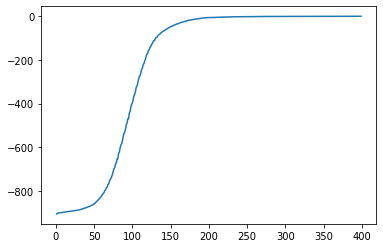

In [34]:
training = pd.read_csv(trainer.logdir + 'progress.csv')
plt.plot(training['episode_reward_mean'])

In [18]:
training['episode_reward_mean']

0             NaN
1     -904.810342
2     -901.939878
3     -901.301369
4     -899.881503
          ...    
395     -0.344406
396     -0.346222
397     -0.164744
398     -0.137492
399     -0.142087
Name: episode_reward_mean, Length: 400, dtype: float64

In [19]:
import torch

In [20]:

env = SimpleMarket(env_config = conf)
obs = env.reset()
done = False
cumulative_reward = 0
prices = []
assets = []
actions = []
states = [obs]
rewards = []
hidden = [torch.zeros(128),torch.zeros(128)]
infos = []
for i in range(9999):
    action, hidden, info = trainer.compute_action(obs, hidden)
    obs, reward, done, results = env.step(action)
    cumulative_reward += reward
    rewards.append(reward)
    actions.append(action)
    asset = env.current_price * env.current_stocks + env.current_money
    assets.append(asset)
    prices.append(env.current_price)
    states.append(obs)
    infos.append(info)
print("Cumulative reward you've received is: {}. Congratulations!".format(cumulative_reward))
print("Asset_Gain {}".format(assets[-1] -assets[0]))
print("Realtive to the market {}".format((assets[-1]/assets[0]) - (prices[-1]/prices[0])))
print('Percentage of capital {}'.format(assets[-1]/assets[0]))
print("Market Change {}".format((prices[-1]/prices[0])))

Cumulative reward you've received is: 4.073802425384473. Congratulations!
Asset_Gain 4.073802425384429
Realtive to the market -0.21138713184497515
Percentage of capital 1.0040738024253844
Market Change 1.2154609342703595


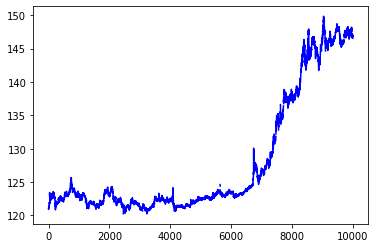

In [21]:
sell100 = np.ma.masked_where(np.array(actions) != 6, prices)
buy10 = np.ma.masked_where(np.array(actions) != 1, prices)
sell10 = np.ma.masked_where(np.array(actions) != 4, prices)
buy50 = np.ma.masked_where(np.array(actions) != 2, prices)
sell50 = np.ma.masked_where(np.array(actions) != 5, prices)
buy100 = np.ma.masked_where(np.array(actions) != 3, prices)
hold = np.ma.masked_where(np.array(actions) != 0, prices)
plt.plot(sell10, c = 'yellow')

plt.plot(buy10, c = 'turquoise')
plt.plot(buy50, c = 'lime')
plt.plot(buy100, c = 'green')
plt.plot(sell50, c = 'orange')
plt.plot(sell100, c = 'red')
plt.plot(hold, c = 'blue')

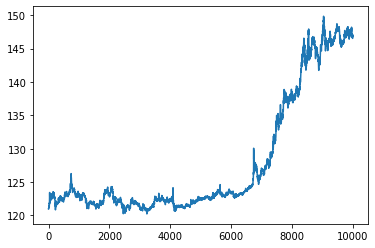

In [22]:
plt.plot(prices)

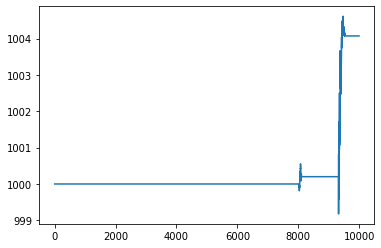

In [23]:
plt.plot(assets)

In [24]:
actions

[0,
 0,
 4,
 0,
 0,
 5,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,


In [25]:

env = SimpleMarket(env_config = conf)
obs = env.test()

done = False
cumulative_reward = 0
prices = []
assets = []
actions = []
states = [obs]
rewards = []
hidden = [torch.zeros(512),torch.zeros(512)]
infos = []
for i in range(25000):
    action, hidden, info = trainer.compute_action(obs, hidden)
    obs, reward, done, results = env.step(action)
    cumulative_reward += reward
    rewards.append(reward)
    actions.append(action)
    asset = env.current_price * env.current_stocks + env.current_money
    assets.append(asset)
    prices.append(env.current_price)
    states.append(obs)
    infos.append(info)
print("Cumulative reward you've received is: {}. Congratulations!".format(cumulative_reward))
print("Asset_Gain {}".format(assets[-1] -assets[0]))
print("Realtive to the market {}".format(((assets[-1]/assets[0])/(prices[-1]/prices[0]))- 1))
print('Percentage of capital {}'.format(assets[-1]/assets[0]))
print("Market Change {}".format((prices[-1]/prices[0])))

Cumulative reward you've received is: -1.917669000131231. Congratulations!
Asset_Gain -1.9176690001312409
Realtive to the market 0.27623753759603176
Percentage of capital 0.9980823309998688
Market Change 0.7820505992010653


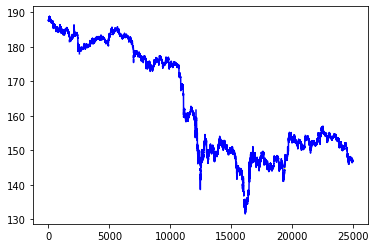

In [26]:
sell100 = np.ma.masked_where(np.array(actions) != 6, prices)
buy10 = np.ma.masked_where(np.array(actions) != 1, prices)
sell10 = np.ma.masked_where(np.array(actions) != 4, prices)
buy50 = np.ma.masked_where(np.array(actions) != 2, prices)
sell50 = np.ma.masked_where(np.array(actions) != 5, prices)
buy100 = np.ma.masked_where(np.array(actions) != 3, prices)
hold = np.ma.masked_where(np.array(actions) != 0, prices)

plt.plot(buy10, c = 'turquoise')
plt.plot(buy50, c = 'lime')
plt.plot(buy100, c = 'green')
plt.plot(sell10, c = 'yellow')
plt.plot(sell50, c = 'orange')
plt.plot(sell100, c = 'red')
plt.plot(hold, c = 'blue')

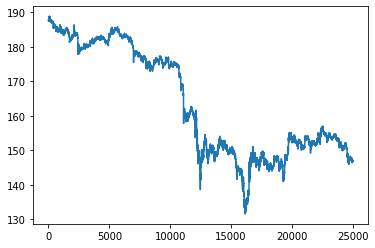

In [27]:
plt.plot(prices)

In [28]:
actions

[0,
 0,
 0,
 4,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 5,
 0,
 4,
 0,
 0,
 0,
 0,
 5,
 4,
 4,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 4,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,


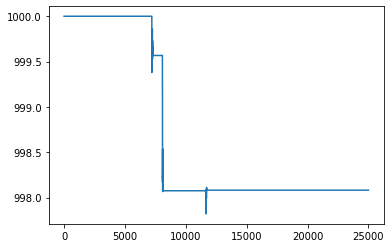

In [29]:
plt.plot(assets)

In [30]:
training['hist_stats/episode_reward'].values[-1]

'[-0.45957626880975616, -1.7742656106071761, -0.42449178564836265, -1.6027988940573283, 0.0, -0.49478609272481905, -3.361589268604877, 0.0, 0.0, 0.0, 0.0, 0.3273649141342127, -0.7277524448696324, 0.6189236662740494, -1.5969777136213914, -1.946729265603571, -0.29443555392110543, 0.0, -1.7242801748902603, -0.4345937917452263, 0.041591523021164055, -0.166705714248859, 0.0, 0.0, 0.0, 0.0, -0.34842748806231705, -0.6214366288902264, -0.9348685052257567, 0.0, -3.2725812356736017, 0.0, 0.0, 2.3193954182309335, 0.2880644207921381, 0.0, -0.33472730643847604, 0.0, -0.20854900439716584, -0.7089929617831188, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7131687840633353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09655022514146014, 0.0, 0.0, -2.116382607452537, 0.0, 0.0, 0.0, -0.15465304149309664, 0.0, 0.0, 0.0, -0.21082623476508822, -0.5847705933756151, -2.9581296179811254, 0.013550659962294709, 0.0, 1.8259197648969203, -0.5268194524007571, 0.0, -1.7281160422088049, -0.27088181771053, 0.0, -0.17492570686038947, -0.413562

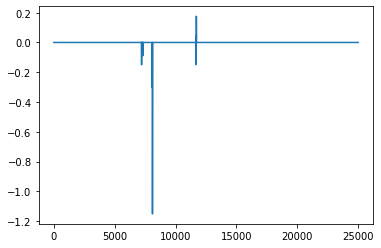

In [31]:
plt.plot(rewards)